# DSCI 632 - Applied Cloud Computing - Final Project

### Team Members
- Aman Ostwal (ago34@drexel.edu)
- Darshit Rai (dr3264@drexel.edu)
- Sanskruti Chavanke (sc4323@drexel.edu)

Downloading and Installing PySpark, FindSpark

In [0]:
# Install the `findspark` and `pyspark` package quietly
# !pip install -q findspark pyspark

# Import the `os` module for operating system functionalities
import os

CSV Files Uploaded - Their Links

The following lines indicate that files have been uploaded to specific directories.

These files are CSV and are located in the "/Volumes/dsci_632_final_project/default/data/" directory.

In [0]:
"""
File uploaded to /Volumes/dsci_632_final_project/default/data/links.csv
File uploaded to /Volumes/dsci_632_final_project/default/data/movies.csv
File uploaded to /Volumes/dsci_632_final_project/default/data/tags.csv
File uploaded to /Volumes/dsci_632_final_project/default/data/ratings.csv
"""

'\nFile uploaded to /Volumes/dsci_632_final_project/default/data/links.csv\nFile uploaded to /Volumes/dsci_632_final_project/default/data/movies.csv\nFile uploaded to /Volumes/dsci_632_final_project/default/data/tags.csv\nFile uploaded to /Volumes/dsci_632_final_project/default/data/ratings.csv\n'

Import Necessary Libraries and Functions

In [0]:
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations
from pyspark import SparkContext  # Spark context for Spark operations
from pyspark.sql import SparkSession  # Spark session for working with SQL
import pyspark.sql.functions as F  # Spark SQL functions
from pyspark.sql.types import TimestampType  # Data type for timestamps
import textwrap  # For text wrapping

In [0]:
def calculate_sparsity(spark_df, rating_col="rating", userId_col="userId", movieId_col="movieId"):
    # Get number of ratings in the dataset
    numerator = spark_df.select(rating_col).count()

    # Get number of distinct users and movies
    users_count = spark_df.select(userId_col).distinct().count()
    movies_count = spark_df.select(movieId_col).distinct().count()

    # Get number of total possible ratings
    denominator = users_count * movies_count

    # Calculate sparsity (num ratings / num possible ratings)
    sparsity = (1.0 - (numerator * 1.0) / denominator) * 100
    print(f"The ratings dataframe is {sparsity:.2f}% empty.")

In [0]:
import numpy as np
import textwrap

def get_formatted_columns(spark_df, col_name):
    # Calculate the mean length of strings in the column
    mean_length = spark_df.selectExpr(f"mean(length({col_name})) as mean_length").collect()[0]["mean_length"]
    
    # Wrap each string in the column to have equal length
    titles = spark_df.select(col_name).rdd.map(lambda x: "\n".join(textwrap.wrap(x[0], int(mean_length)))).collect()

    return titles

# Import Data and Pre-Processing

### Import Data

In [0]:
# Import necessary modules
from pyspark import SparkContext  # For Spark context
from pyspark.sql import SparkSession  # For Spark session

# Create or get SparkContext (sc)
sc = SparkContext.getOrCreate()

# Create or get SparkSession (spark)
spark = SparkSession.builder.getOrCreate()

In [0]:
# Define the file path where the ratings CSV file is located
file_path = "/Volumes/dsci_632_final_project/default/data/ratings.csv"

# Read the ratings CSV file into a Spark DataFrame, assuming it has a header and inferSchema is enabled
ratings = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first 5 rows of the ratings DataFrame
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows



Explanation of columns:

- ```userId```: A unique identifier for a user.
- ```movieId```: MovieLens ID for movies.
- ```rating```: Rating given by the user, on a scale of 0.5 to 5.0.
- ```timestamp```: Time of rating, expressed in the number of Unix seconds since January 1, 1970.

In [0]:
from pyspark.sql import functions as F  # Import Spark SQL functions

# Calculate the total number of ratings
num_ratings = ratings.count()

# Calculate the number of distinct users
num_users = ratings.select(F.countDistinct('userId')).first()[0]

# Calculate the number of distinct movies
num_movies = ratings.select(F.countDistinct('movieId')).first()[0]

# Print the results
print(f"Number of Ratings: {num_ratings}")
print(f"Number of Distinct Users: {num_users}")
print(f"Number of Distinct Movies: {num_movies}")

Number of Ratings: 25000095
Number of Distinct Users: 162541
Number of Distinct Movies: 59047


#Preprocessing

#### Checking Datatypes

In [0]:
# Print the schema of the ratings DataFrame
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



#### No Duplicate Ratings

Confirm there are no duplicates of ```movieId``` and ```userId``` (i.e., no double ratings for a given movie-user pair).

In [0]:
# Group the ratings DataFrame by userId and movieId, and count the occurrences
grouped_ratings = ratings.groupBy("userId", "movieId").count()

# Select the maximum count value
max_count = grouped_ratings.select(F.max("count")).show()

+----------+
|max(count)|
+----------+
|         1|
+----------+



#### Sparsity

As a last quality check, we'll determine the sparsity of our dataset.

In [0]:
# Call the function calculate_sparsity with the ratings DataFrame as input
calculate_sparsity(ratings)

The ratings dataframe is 99.74% empty.


Recommender Systems usually have about ```99% sparsity```, so this is normal, if not more populated than usual.

#### Join Data for Readability

```userId```, ```movieId```, and ```rating``` are of the appropriate datatypes to continue analysis. We'll join ratings with the actual movie titles for readability purposes.

In [0]:
# Define the file path where the movies CSV file is located
file_path = "/Volumes/dsci_632_final_project/default/data/movies.csv"

# Read the movies CSV file into a Spark DataFrame, assuming it has a header and inferSchema is enabled
titles = spark.read.csv(file_path, header=True, inferSchema=True)

# Select only the "movieId" and "title" columns from the DataFrame and remove the "genres" column
titles = titles.select("movieId", "title")

# Show the first 5 rows of the titles DataFrame without truncating the column values
titles.show(5, truncate=False)

+-------+----------------------------------+
|movieId|title                             |
+-------+----------------------------------+
|1      |Toy Story (1995)                  |
|2      |Jumanji (1995)                    |
|3      |Grumpier Old Men (1995)           |
|4      |Waiting to Exhale (1995)          |
|5      |Father of the Bride Part II (1995)|
+-------+----------------------------------+
only showing top 5 rows



In [0]:
# Join the ratings DataFrame with the titles DataFrame on the "movieId" column using a left join
movie_ratings = ratings.join(titles, on="movieId", how="left")

# Show the first 5 rows of the joined DataFrame without truncating the column values
movie_ratings.show(5, truncate=False)

+-------+------+------+----------+------------------------------------------------+
|movieId|userId|rating|timestamp |title                                           |
+-------+------+------+----------+------------------------------------------------+
|296    |1     |5.0   |1147880044|Pulp Fiction (1994)                             |
|306    |1     |3.5   |1147868817|Three Colors: Red (Trois couleurs: Rouge) (1994)|
|307    |1     |5.0   |1147868828|Three Colors: Blue (Trois couleurs: Bleu) (1993)|
|665    |1     |5.0   |1147878820|Underground (1995)                              |
|899    |1     |3.5   |1147868510|Singin' in the Rain (1952)                      |
+-------+------+------+----------+------------------------------------------------+
only showing top 5 rows



Next, we'll convert the ```timestamp``` from Unix seconds since 1/1/1970 to a more readable date.

In [0]:
# Import necessary functions and data types from PySpark
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType

# Convert the "timestamp" column from Unix seconds to a timestamp type
movie_ratings = movie_ratings.withColumn("timestamp", F.from_unixtime("timestamp"))

# Show the updated DataFrame
movie_ratings.show(10, truncate=False)

+-------+------+------+-------------------+------------------------------------------------+
|movieId|userId|rating|timestamp          |title                                           |
+-------+------+------+-------------------+------------------------------------------------+
|296    |1     |5.0   |2006-05-17 15:34:04|Pulp Fiction (1994)                             |
|306    |1     |3.5   |2006-05-17 12:26:57|Three Colors: Red (Trois couleurs: Rouge) (1994)|
|307    |1     |5.0   |2006-05-17 12:27:08|Three Colors: Blue (Trois couleurs: Bleu) (1993)|
|665    |1     |5.0   |2006-05-17 15:13:40|Underground (1995)                              |
|899    |1     |3.5   |2006-05-17 12:21:50|Singin' in the Rain (1952)                      |
|1088   |1     |4.0   |2006-05-17 12:21:35|Dirty Dancing (1987)                            |
|1175   |1     |3.5   |2006-05-17 12:27:06|Delicatessen (1991)                             |
|1217   |1     |3.5   |2006-05-17 15:05:26|Ran (1985)                 

Finally, we'll reorganize the columns for the ALS (Alternating Least Squares) algorithm.

In [0]:
# Reorganize the columns for the ALS algorithm
movie_ratings = movie_ratings.select("title", "movieId", "userId", "rating", "timestamp")

# Show the first 5 rows of the reorganized DataFrame without truncating the column values
movie_ratings.show(10, truncate=False)

+------------------------------------------------+-------+------+------+-------------------+
|title                                           |movieId|userId|rating|timestamp          |
+------------------------------------------------+-------+------+------+-------------------+
|Pulp Fiction (1994)                             |296    |1     |5.0   |2006-05-17 15:34:04|
|Three Colors: Red (Trois couleurs: Rouge) (1994)|306    |1     |3.5   |2006-05-17 12:26:57|
|Three Colors: Blue (Trois couleurs: Bleu) (1993)|307    |1     |5.0   |2006-05-17 12:27:08|
|Underground (1995)                              |665    |1     |5.0   |2006-05-17 15:13:40|
|Singin' in the Rain (1952)                      |899    |1     |3.5   |2006-05-17 12:21:50|
|Dirty Dancing (1987)                            |1088   |1     |4.0   |2006-05-17 12:21:35|
|Delicatessen (1991)                             |1175   |1     |3.5   |2006-05-17 12:27:06|
|Ran (1985)                                      |1217   |1     |3.5  

# EDA (Exploratory Data Analysis)

#### Movie and User Summary Statistics

Let's see the top ```movies``` and ```users```.

In [0]:
# Group the movie_ratings DataFrame by "title" and count the occurrences
# Then, order the result by count in descending order and show the top 10 titles
movie_ratings.select("title", "movieId").groupBy("title").count().orderBy("count", ascending=False).show(10, truncate=False)

+-----------------------------------------+-----+
|title                                    |count|
+-----------------------------------------+-----+
|Forrest Gump (1994)                      |81491|
|Shawshank Redemption, The (1994)         |81482|
|Pulp Fiction (1994)                      |79672|
|Silence of the Lambs, The (1991)         |74127|
|Matrix, The (1999)                       |72674|
|Star Wars: Episode IV - A New Hope (1977)|68717|
|Jurassic Park (1993)                     |64144|
|Schindler's List (1993)                  |60411|
|Braveheart (1995)                        |59184|
|Fight Club (1999)                        |58773|
+-----------------------------------------+-----+
only showing top 10 rows



In [0]:
# Group the movie_ratings DataFrame by "userId" and count the occurrences
# Then, order the result by count in descending order and show the top 10 user IDs
movie_ratings.groupBy("userId").count().orderBy("count", ascending=False).show(10, truncate=False)

+------+-----+
|userId|count|
+------+-----+
|72315 |32202|
|80974 |9178 |
|137293|8913 |
|33844 |7919 |
|20055 |7488 |
|109731|6647 |
|92046 |6564 |
|49403 |6553 |
|30879 |5693 |
|115102|5649 |
+------+-----+
only showing top 10 rows



Next, we'll identify the first and last rating ```timestamp```.

In [0]:
# Select the minimum timestamp from the movie_ratings DataFrame
movie_ratings.select(F.min("timestamp")).show()

+-------------------+
|     min(timestamp)|
+-------------------+
|1995-01-09 11:46:49|
+-------------------+



In [0]:
# Select the maximum timestamp from the movie_ratings DataFrame
movie_ratings.select(F.max("timestamp")).show()

+-------------------+
|     max(timestamp)|
+-------------------+
|2019-11-21 09:15:03|
+-------------------+



# Visualizations in ```matplotlib```

#### Plotting all Data

We'll now convert the PySpark DataFrames from above to ```pandas``` DataFrames to create some visualizations. First, we'll recreate the DataFrames and plot all the data to see the overall distribution.

In [0]:
# Convert the movie_ratings DataFrame from PySpark to a pandas DataFrame
pandas_movie_ratings = movie_ratings.toPandas()

# Display the first few rows of the pandas DataFrame
pandas_movie_ratings.head()

,title,movieId,userId,rating,timestamp
0,Pulp Fiction (1994),296,1,5.0,2006-05-17 15:34:04
1,Three Colors: Red (Trois couleurs: Rouge) (1994),306,1,3.5,2006-05-17 12:26:57
2,Three Colors: Blue (Trois couleurs: Bleu) (1993),307,1,5.0,2006-05-17 12:27:08
3,Underground (1995),665,1,5.0,2006-05-17 15:13:40
4,Singin' in the Rain (1952),899,1,3.5,2006-05-17 12:21:50


In [0]:
# Convert the PySpark DataFrame titles to a pandas DataFrame
movie_titles = titles.toPandas()  # Convert PySpark DataFrame to pandas DataFrame

# Display the first few rows of the pandas DataFrame
movie_titles.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [0]:
# Create a copy of the pandas DataFrame pandas_movie_ratings
pandas_movie = pandas_movie_ratings.copy()

# Count the number of ratings for each movie and select only the "movieId" and "userId" columns
pandas_movie_ind = pandas_movie.groupby("movieId", as_index=False).count()[["movieId", "userId"]]

# Merge the tables to get titles (groupby operation deletes title index values)
pandas_movie_counts = movie_titles.merge(pandas_movie_ind, on="movieId")

# Set the index to "title" for plotting
pandas_movie_counts = pandas_movie_counts.set_index("title")

# Rename the columns for readability
pandas_movie_counts = pandas_movie_counts.rename(columns={"userId": "num_ratings"})
pandas_movie_counts.head()

,movieId,num_ratings
title,,
Toy Story (1995),1,57309
Jumanji (1995),2,24228
Grumpier Old Men (1995),3,11804
Waiting to Exhale (1995),4,2523
Father of the Bride Part II (1995),5,11714


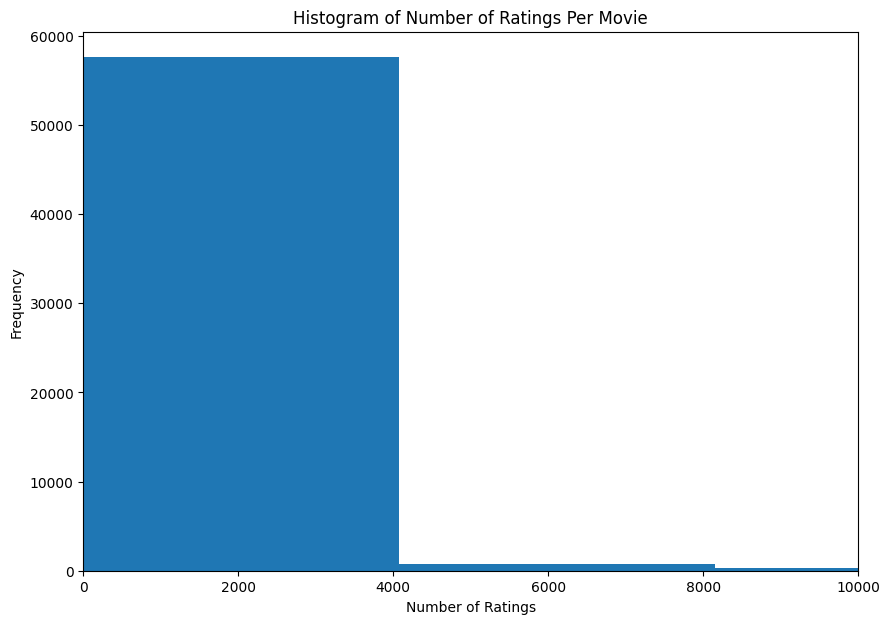

In [0]:
# Import the necessary library for plotting
import matplotlib.pyplot as plt

# Create a new figure and axis object
fig, ax = plt.subplots()

# Create a histogram of the number of ratings per movie using the pandas DataFrame pandas_movie_counts
ax.hist(pandas_movie_counts.num_ratings, bins=20)

# Customize the appearance of the plot
fig.set_size_inches([10, 7])  # Set the size of the figure
plt.xlim([0, 10000])  # Set the x-axis limits
ax.set_title("Histogram of Number of Ratings Per Movie")  # Set the title of the plot
ax.set_xlabel("Number of Ratings")  # Set the label for the x-axis
ax.set_ylabel("Frequency")  # Set the label for the y-axis

# Display the plot
plt.show()

In [0]:
# Create a copy of the pandas DataFrame pandas_movie_ratings
pandas_user = pandas_movie_ratings.copy()

# Count the number of ratings for each user and select only the "userId" and "rating" columns
pandas_user_ind = pandas_user.groupby("userId", as_index=False).count()[["userId", "rating"]]

# Rename the columns for readability
pandas_user_counts = pandas_user_ind.rename(columns={"rating": "num_ratings"})
pandas_user_counts.head()

,userId,num_ratings
0,1,70
1,2,184
2,3,656
3,4,242
4,5,101


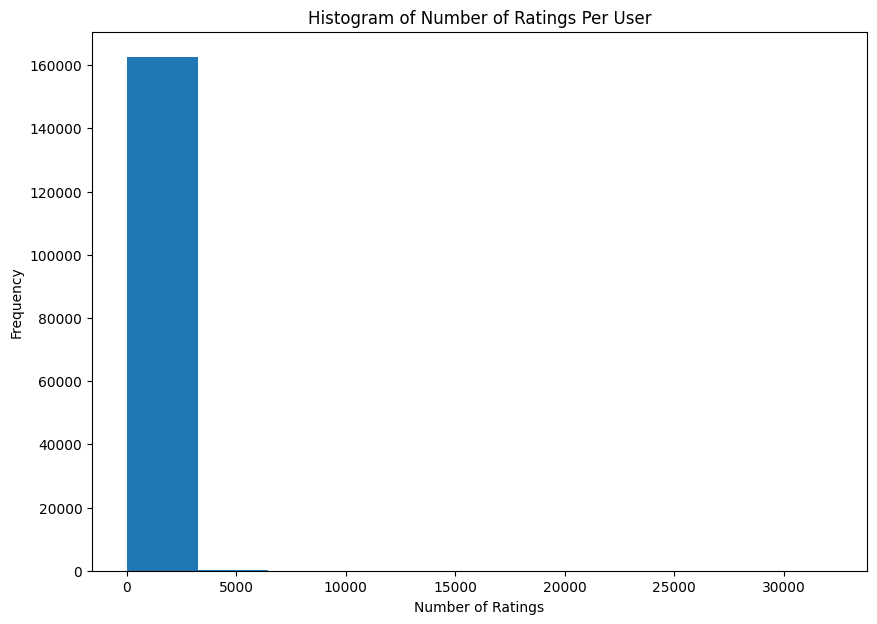

In [0]:
# Create a new figure and axis object
fig, ax = plt.subplots()

# Create a histogram of the number of ratings per user using the pandas DataFrame pandas_user_counts
ax.hist(pandas_user_counts.num_ratings)

# Customize the appearance of the plot
fig.set_size_inches([10, 7])  # Set the size of the figure
ax.set_title("Histogram of Number of Ratings Per User")  # Set the title of the plot
ax.set_xlabel("Number of Ratings")  # Set the label for the x-axis
ax.set_ylabel("Frequency")  # Set the label for the y-axis

# Display the plot
plt.show()

#### Plotting Movies and Users

The skewed data is hard to see plotted all at once. We'll take advantage of the PySpark DataFrames we created earlier and save them to ```top_movies``` and ```top_users``` to create bar charts of the top 10 movies and users.

In [0]:
# Select the top 10 movies based on the number of ratings
top_movies = movie_ratings.select("title", "movieId").groupBy("title") \
    .count().orderBy("count", ascending=False).toPandas()
top_movies = top_movies.iloc[:10,:]
top_movies.head(10)

,title,count
0,Forrest Gump (1994),81491
1,"Shawshank Redemption, The (1994)",81482
2,Pulp Fiction (1994),79672
3,"Silence of the Lambs, The (1991)",74127
4,"Matrix, The (1999)",72674
5,Star Wars: Episode IV - A New Hope (1977),68717
6,Jurassic Park (1993),64144
7,Schindler's List (1993),60411
8,Braveheart (1995),59184
9,Fight Club (1999),58773


In [0]:
# Select the least popular 10 movies based on the number of ratings
least_popular_movies = movie_ratings.select("title", "movieId").groupBy("title") \
    .count().orderBy("count", ascending=True).toPandas()
least_popular_movies = least_popular_movies.iloc[:10,:]
least_popular_movies.head(10)

,title,count
0,Adventures of Rusty (1945),1
1,A Yank at Oxford (1938),1
2,Hinterdupfing (2014),1
3,Disgruntled (2008),1
4,The Sailor Takes a Wife (1945),1
5,My Mighty Princess (2008),1
6,A Gift of Miracles (2015),1
7,The Olsen Gang in a Fix (1969),1
8,The Most Beautiful Wife (1970),1
9,"Geek, and You Shall Find (2019)",1


/root/.ipykernel/81206/command-310017768511149-2575990156:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(get_formatted_columns(top_movies["title"]), rotation=90)  # Set x-axis labels with text wrapping


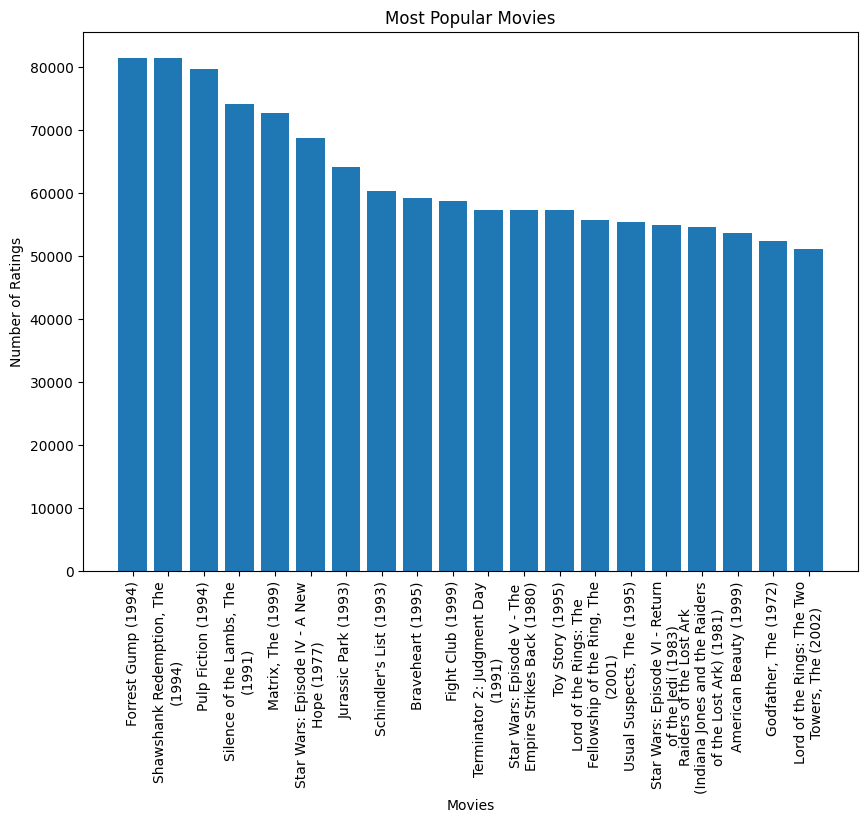

In [0]:
# Define the function get_formatted_columns to format column labels
def get_formatted_columns(titles):
    """Reformats column labels with newline inserts (\n) for better visualization."""
    # Calculate the mean length of column labels
    mean_length = int(sum(len(title) for title in titles) / len(titles))
    # Wrap each column label to have equal length
    formatted_titles = ["\n".join(textwrap.wrap(title, mean_length)) for title in titles]
    return formatted_titles

# Select the top 10 movies based on the number of ratings
top_movies = movie_ratings.select("title", "movieId").groupBy("title") \
    .count().orderBy("count", ascending=False).limit(20).toPandas()

# Create a new figure and axis object
fig, ax = plt.subplots()

# Create a bar plot of the top 10 movies
ax.bar(x=top_movies["title"], height=top_movies["count"])

# Customize the appearance of the plot
fig.set_size_inches([10, 7])  # Set the size of the figure
ax.set_title("Most Popular Movies")  # Set the title of the plot
ax.set_xlabel("Movies")  # Set the label for the x-axis
ax.set_ylabel("Number of Ratings")  # Set the label for the y-axis
ax.set_xticklabels(get_formatted_columns(top_movies["title"]), rotation=90)  # Set x-axis labels with text wrapping

# Display the plot
plt.show()

/root/.ipykernel/81206/command-2391232098775432-1304039754:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(get_formatted_columns(lowest_movies["title"]), rotation=90)  # Set x-axis labels with text wrapping


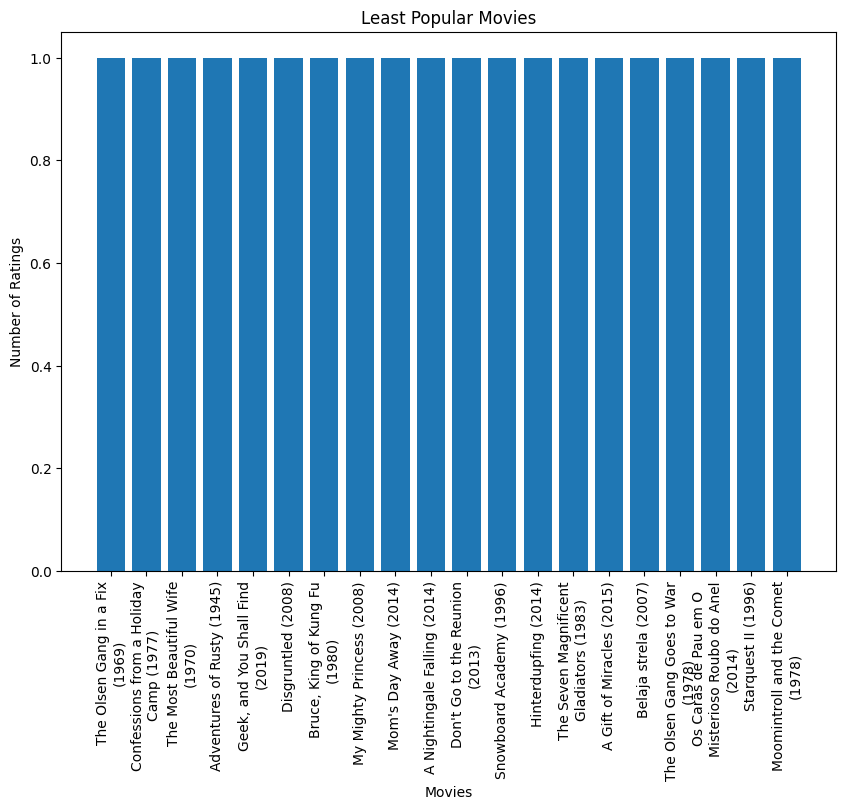

In [0]:
# Select the lowest 10 movies based on the number of ratings
lowest_movies = movie_ratings.select("title", "movieId").groupBy("title") \
    .count().orderBy("count", ascending=True).limit(20).toPandas()

# Create a new figure and axis object
fig, ax = plt.subplots()

# Create a bar plot of the lowest 10 movies
ax.bar(x=lowest_movies["title"], height=lowest_movies["count"])

# Customize the appearance of the plot
fig.set_size_inches([10, 7])  # Set the size of the figure
ax.set_title("Least Popular Movies")  # Set the title of the plot for the lowest rated movies
ax.set_xlabel("Movies")  # Set the label for the x-axis
ax.set_ylabel("Number of Ratings")  # Set the label for the y-axis
ax.set_xticklabels(get_formatted_columns(lowest_movies["title"]), rotation=90)  # Set x-axis labels with text wrapping

# Display the plot
plt.show()

In [0]:
# Select the top 10 users based on the number of ratings
top_users = movie_ratings.select("userId", "rating").groupBy("userId") \
    .count().orderBy("count", ascending=False).limit(10).toPandas()

# Get the top 10 users
top_users = top_users.iloc[:10, :]

# Convert the "userId" column to string for plotting
top_users["userId"] = top_users["userId"].astype(str)

/root/.ipykernel/81206/command-310017768511151-418249866:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_users["userId"])  # Set x-axis labels


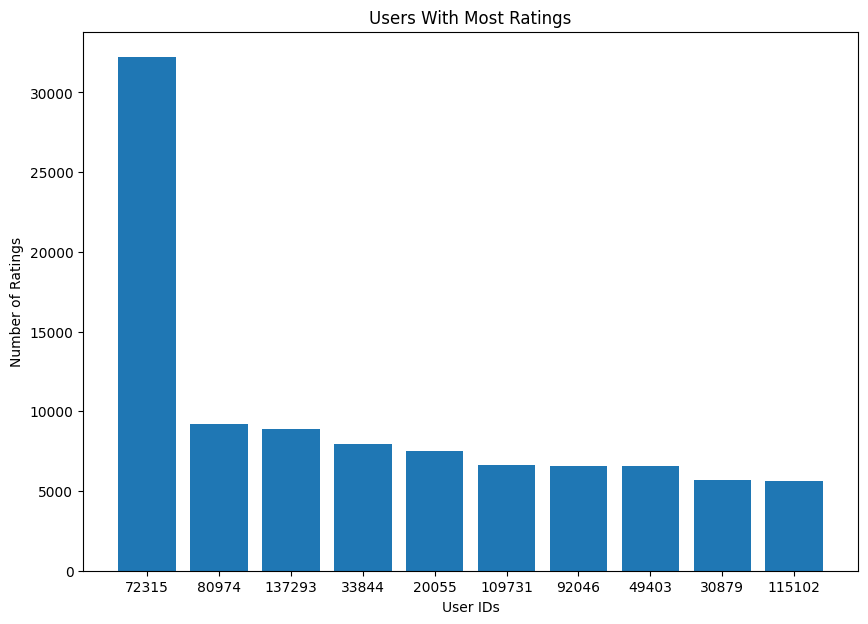

In [0]:
# Create a new figure and axis object
fig, ax = plt.subplots()

# Create a bar plot of the top 10 users
ax.bar(x=top_users["userId"], height=top_users["count"])

# Customize the appearance of the plot
fig.set_size_inches([10, 7])  # Set the size of the figure
ax.set_title("Users With Most Ratings")  # Set the title of the plot
ax.set_xlabel("User IDs")  # Set the label for the x-axis
ax.set_ylabel("Number of Ratings")  # Set the label for the y-axis
ax.set_xticklabels(top_users["userId"])  # Set x-axis labels

# Display the plot
plt.show()

#### Movies by Year

Each movie contains the year it was made. We'll use ```regex``` to extract these dates to gain insight on which years are the most popular for rating on MovieLens with this dataset.

In [0]:
# Reset index to get titles
pandas_by_year = pandas_movie_counts.reset_index()

# Extract years from each title using regular expressions
pandas_by_year["year"] = pandas_by_year["title"].str.extract('\((\d{4})\)$')

# Get movies that failed to convert
failed_to_convert_movies = pandas_by_year[pandas_by_year["year"].isnull()]

# Calculate the percentage of movies that failed to convert
percent_failed = failed_to_convert_movies.shape[0] / num_movies * 100

# Print the number and percentage of movies that failed to convert
print(f"Failed to convert {failed_to_convert_movies.shape[0]} or {percent_failed:.2f}% of movies")

Failed to convert 538 or 0.91% of movies


In [0]:
# Display movies that failed to convert the year
failed_to_convert_movies_df = spark.createDataFrame(failed_to_convert_movies)
failed_to_convert_movies_df.show(10, truncate = False)

+--------------------------------------------------------------------------------+-------+-----------+----+
|title                                                                           |movieId|num_ratings|year|
+--------------------------------------------------------------------------------+-------+-----------+----+
|"11'09""01 - September 11 (2002)"                                               |7789   |121        |NULL|
|Babe Ruth Story, The (1948)                                                     |25936  |6          |NULL|
|Heroes of Telemark, The (1965)                                                  |26137  |22         |NULL|
|Jack's Back (1988)                                                              |26628  |18         |NULL|
|After the Rain (Ame agaru) (1999)                                               |27189  |23         |NULL|
|Love Letter (1995)                                                              |32497  |38         |NULL|
|Acts of Worship (2001)     

Nearly all have 1 rating, most have no movie dates or are actually television shows. Considering we have only failed 0.91% of movies and the focus of this project is a recommender system, this is the EDA portion, and not necessarily an exercise in regular expression. We'll stick with this crude conversion for now.

In [0]:
# Remove rows with NaN values in the "year" column and confirm removal
pandas_by_year = pandas_by_year[pandas_by_year.year.notnull()]
pandas_by_year.isnull().any()

title          False
movieId        False
num_ratings    False
year           False
dtype: bool

In [0]:
import pandas as pd

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
pandas_by_year = pandas_by_year.copy()

# Create a datetime column from the "year" column
pandas_by_year["date"] = pd.to_datetime(pandas_by_year["year"], format="%Y")

# Use the "date" column to convert the "year" column to datetime
pandas_by_year["year"] = pandas_by_year["date"].dt.year

In [0]:
# Display the schema of the PySpark DataFrame
pandas_by_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58509 entries, 0 to 59046
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        58509 non-null  object        
 1   movieId      58509 non-null  int32         
 2   num_ratings  58509 non-null  int64         
 3   year         58509 non-null  int64         
 4   date         58509 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 2.5+ MB


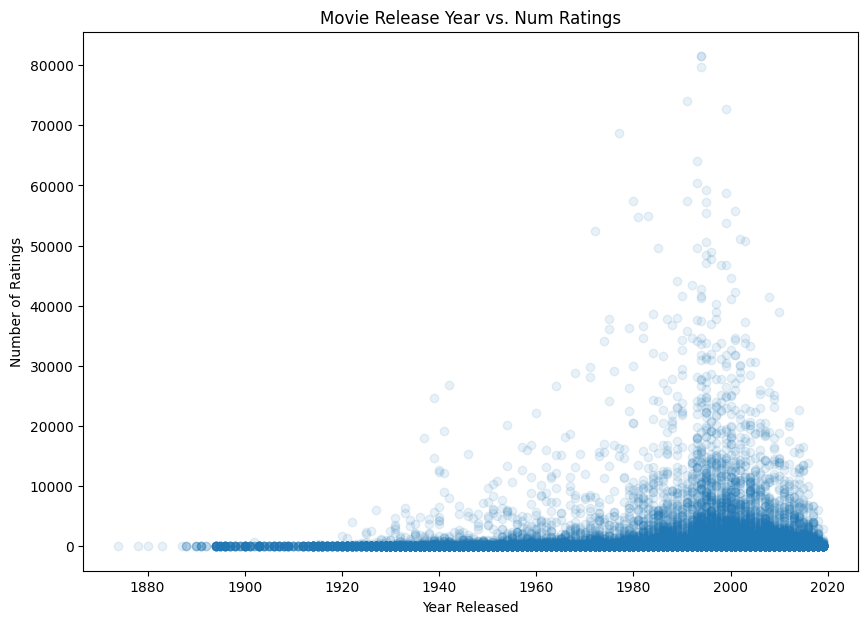

In [0]:
# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(pandas_by_year["year"], pandas_by_year["num_ratings"], alpha=0.1)

# Customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Movie Release Year vs. Num Ratings")
ax.set_xlabel("Year Released")
ax.set_ylabel("Number of Ratings")
plt.show()

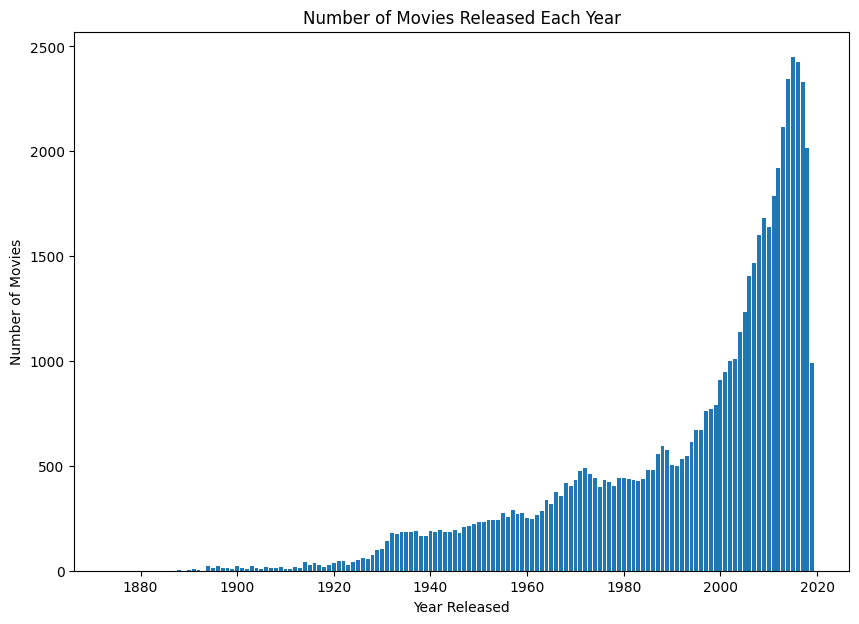

In [0]:
# Group by year and count the number of movies
pandas_by_year_counts = pandas_by_year.groupby("year").size().reset_index(name="num_ratings")

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(pandas_by_year_counts["year"], pandas_by_year_counts["num_ratings"])

# Customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Number of Movies Released Each Year")
ax.set_xlabel("Year Released")
ax.set_ylabel("Number of Movies")
plt.show()